## Summary

In this blog post, we will explore a toy classification example using the Fashion MNIST dataset. We will discuss the limitations of the fastai DataBlock API and how learning about the Mid-level API can help overcome these limitations using Transforms, Pipeline, and Datasets. We will also cover the debugging steps involved in creating the Dataloaders for training image classifier & deploy the app using Gradio & HuggingFace spaces. See the complete app [Code](https://huggingface.co/spaces/msivanes/fashion-mnist-classifier/blob/main/app.py) & [Space](https://huggingface.co/spaces/msivanes/fashion-mnist-classifier)

## Setup

In [ ]:
#hide
#%pip install fastbook -qqq > /dev/null

In [ ]:
#hide
from fastbook import *

In [ ]:
#hide
# %pip install datasets -qqq > /dev/null
# %pip install nbdev fastcore fastai -qqq > /dev/null
# %pip install gradio -qqq > /dev/null

In [ ]:
#hide
from nbdev.showdoc import show_doc
from datasets import load_dataset, load_dataset_builder, concatenate_datasets, ClassLabel
from fastai.vision.all import *
import gradio as gr
from fastai.learner import load_learner

In [ ]:
#hide
# show_doc(load_dataset)
# show_doc(load_dataset_builder)

## Context

When working with the [fastai library](https://docs.fast.ai), we may encounter situations where the [Data block API](https://docs.fast.ai/tutorial.datablock.html) is not flexible enough to handle our specific data processing needs. In such cases, we can use fastai's mid-level API, which provides a more comprehensive set of tools for processing data. The mid-level API includes a range of features such as Transforms, Pipeline, TfmdLists, Datasets, Callbacks, and General Optimizer. By using these, we can overcome the limitations of the Data block API and create more customized data processing pipelines to suit our specific use case.

To read more about Mid-Level API, please refer [Chapter 11 - Data Munging with fastai's Mid-Level API](https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb) in fastbook.

![fastai - a Layered API](https://www.fast.ai/images/fastai_paper/layered.PNG)

In this post, I wanted to share a toy classification example using Fashion MNIST dataset where the DataBlock API is not flexibile and how learning about Mid-level API using `Transforms`, `Pipeline` and `Datasets` helped to create the Dataloaders for training the model. We will use the model to create a image classifier predicting the target class given an black & white image of a fashion apparel using Gradio and HuggingFace spaces. We will also cover the debugging steps involved at the relevant step.

The end to end workflow is as follows

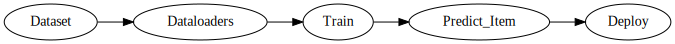

In [ ]:
#hide_input
gv('''
Dataset -> Dataloaders -> Train -> Predict_Item -> Deploy
''')

## Exploring the Dataset

- Download and load dataset with the name `fashion_mnist` from https://huggingface.co/datasets/fashion_mnist using HuggingFace **datasets** library.

> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 apparels such as t-shirt, ankle boot,

- Explore the dataset using `load_dataset_builder` inspecting the dataset info such as description, features, splits etc

In [ ]:
name='fashion_mnist'
ds_builder = load_dataset_builder(name)

In [ ]:
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
print(ds_builder.info.features)

{'image': Image(decode=True, id=None), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}


In [ ]:
print(ds_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None), 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}


In [ ]:
ds_builder.info.features['label']

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [ ]:
ds_builder.info.features['label'].int2str(9)

'Ankle boot'

-  Load the dataset from the Hugging Face Hub specifying the name.

In [ ]:
dset = load_dataset(name)

This is a `DatasetDict` containing a `train` and `test` dataset dictionary within this object.

In [ ]:
dset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

-  We can inspect the individual item within train and test and the different labels.

In [ ]:
dset['train'][0], dset['test'][0]

({'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9})

## Create fastai DataLoaders

We eventually want to create `Datasets` object in fastai from HuggingFace `Dataset`. We will first attempt with the the high level `DataBlock` API and then transition to fastai `Datasets`. 

> DataBlock is a high level API in fastai allowing the user to define the standard steps to prepare the data for deep learning model.

Steps involved to prepare the data
- Identify the types of inputs/targets for your data and define them as "Blocks".
- Specify how to fetch and define any transformations that need to be applied to the inputs using the "get_x" function.
- Specify how to fetch and define any transformations that need to be applied to the targets using the "get_y" function.
- Split the data into training and validation sets using the "splitter" function.
- Apply any additional transformations to the items using the "item_tfms" function.
- Apply any additional transformations to the batches using the "batch_tfms" function.

Let's create training and test sets.

In [ ]:
train, test = dset['train'], dset['test']

Create an `Image` from argument using `PILImageBW.create` function

In [ ]:
im = PILImageBW.create(train[0]['image'])

Display the image using `show` method

<AxesSubplot:>

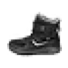

In [ ]:
im.show()

Let's examine the type of the features (ie Image) and label

In [ ]:
type(train[0]['image'])

PIL.PngImagePlugin.PngImageFile

Let's examine the first 3 training samples

In [ ]:
train[:3]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0]}

The type of `label` is an `int` but since fastai also performs `Categorize` transform we can create a separate `target` which contains the original apparel name. This can be achieved using `ClassLabel.int2str` method.

In [ ]:
classLabel = ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

def add_target(x:dict):
    x['target'] = classLabel.int2str(x['label'])
    return x

train = train.map(lambda x: add_target(x))
valid = test.map(lambda x: add_target(x))

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
train[:3], valid[:3]

({'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
   <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
   <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
  'label': [9, 0, 0],
  'target': ['Ankle boot', 'T - shirt / top', 'T - shirt / top']},
 {'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
   <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
   <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
  'label': [9, 2, 1],
  'target': ['Ankle boot', 'Pullover', 'Trouser']})

Now we can concatenate training and validation datasets into a single set of items which can be passed to fastai `Datasets` with index from 60000 to 70000 set aside as validation set.

In [ ]:
concat_dsets = concatenate_datasets([train, valid])

In [ ]:
concat_dsets

Dataset({
    features: ['image', 'label', 'target'],
    num_rows: 70000
})

### Attempting to use DataBlock

Let's first create a `DataBlock` and then learn how to create `Datasets`. In order to inform fastai on how to turn the data into `DataLoaders` object, 4 key pieces of info are needed. 
1. the kind of data used for inputs and the target 
2. Getters for the list of items 
3. Labeling the items 
4. Validation set creation

> Tip: It's best to create `DataBlock` in an iterative manner and running `datablock.summary` to understand the pieces that fastai adds behind the scenes.

In [ ]:
def get_image_attr(x): return x['image']
def get_target_attr(x): return x['target']

In [ ]:
Image.fromarray(array(train[0]['image']))

In [ ]:
def image2tensor(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = tensor(img)
    if res.dim()==2: res = res.unsqueeze(-1)
    return res.permute(2,0,1)

In [ ]:
type(image2tensor(train[0]['image']))

torch.Tensor

We will discuss `image2tensor` function when we discuss `Attempting with Datasets`

This shows how to specify the indices that need to be part of validation set. Indices 6, 7, 8 & 9 are in validation and rest are in training set.

In [ ]:
IndexSplitter(valid_idx=L(range(6, 10)))(concat_dsets)

((#69996) [0,1,2,3,4,5,10,11,12,13...], (#4) [6,7,8,9])

DataBlock definition is as follows

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=Pipeline([get_image_attr, image2tensor]),
                   get_y=get_target_attr,
                   splitter=IndexSplitter(valid_idx=L(range(60000, 70000))),
                   )

Run the `DataBlock.summary` to understand how fastai set up the data pipeline and perform the necessary transforms.

In [ ]:
# Output cleared
# dblock.summary(concat_dsets)

Setting-up type transforms pipelines
    features: ['image', 'label', 'target'],
    num_rows: 70000
})
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: get_image_attr -> image2tensor -> PILBase.create


TypeError: Cannot handle this data type: (1, 1, 28), |u1

Essentially the data pipeline is as follows 
- Get the image attribute from the item, Convert the image to tensor. But fastai also adds the `PILBase.create` since we specified ImageBlock as our independent variable. This caused an issue `KeyError: ((1, 1, 28), '|u1')` due to `Image.fromarray` function used in `PILBase.create`. From https://stackoverflow.com/questions/57621092/keyerror-1-1-1280-u1-while-using-pils-image-fromarray-pil
> Pillow's fromarray function can only do a MxNx3 array (RGB image), or an MxN array (grayscale).     

- Internally fastai calls `load_image` with the item during the data pipeline creation as part of `PILBase.create` which fastai adds by default if we specify `ImageBlock` as part of blocks section in the DataBlock.

In [ ]:
def load_image(fn, mode=None):
    "Open and load a `PIL.Image` and convert to `mode`"
    im = Image.open(fn)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im

`load_image` requires a filename but dataset already is in `PIL.PngImagePlugin.PngImageFile`

`Image.open(train[0]['image'])` will lead to the following error from pillow library.

```
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-18-ed0e9de325b8> in <module>
----> 1 Image.open(train[0]['image'])

1 frames
/usr/local/lib/python3.8/dist-packages/PIL/Image.py in __getattr__(self, name)
    544             )
    545             return self._category
--> 546         raise AttributeError(name)
    547 
    548     @property

```

### Attempt with MidLevel API Datasets

We want to convert the Image of size [28 ,28] into [1, 28, 28] as our end goal and decided to perform the item transforms using Mid Level API instead. - `Datasets` in MidLevel API provides more flexibility and full control over the individual item transforms performed.

> Datasets is part of MidLevel API allowing the user to customize the steps involved in data processing that are
not possible with DataBlockAPI 

Datasets need the following pieces of information 
- raw items
- the list of transforms that builds our inputs from the raw items
- the list of transforms that builds our targets from the raw items
- the split for training and validation

For a deeper dive, refer loading the data with mid level api section on [Training Imagenette tutorial](https://docs.fast.ai/tutorial.imagenette.html#loading-the-data-with-the-mid-level-api) and Wayde Gilliam [blog post](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html)

Let's iterate on the individual pieces of info. 

Let's investigate the item transforms that we need for the Image. PyTorch Model expects the items to of type `torch.Tensor`. So I used `ToTensor` but it did not convert to tensors as I expected for the Image of type `PIL.PngImagePlugin.PngImageFile`. So I created `img2tensor` instead.

In [ ]:
type(train[0]['image'])

PIL.PngImagePlugin.PngImageFile

In [ ]:
type(ToTensor()(train[0]['image']))

PIL.PngImagePlugin.PngImageFile

Referred what fastai does underneath using the source code. This is the function that takes the image and converts the image to a byte tensor of shape `c*h*w` ie channel x height x width

In [ ]:
def image2tensor(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = tensor(img)
    if res.dim()==2: res = res.unsqueeze(-1)
    return res.permute(2,0,1)

In [ ]:
type(image2tensor(train[0]['image']))

torch.Tensor

I created my own version of it in `img2tensor`

In [ ]:
def img2tensor(im: Image.Image):
    return TensorImageBW(array(im)).unsqueeze(0)

In [ ]:
img2tensor(train[0]['image']).shape

torch.Size([1, 28, 28])

In [ ]:
tensor(train[0]['image']).unsqueeze(-1).permute(2,0,1).shape

torch.Size([1, 28, 28])

In [ ]:
TensorImageBW(array(im)).unsqueeze(0).shape

torch.Size([1, 28, 28])

In [ ]:
test_eq([1, 28, 28], img2tensor(train[0]['image']).shape)
test_eq([1, 28, 28], image2tensor(train[0]['image']).shape)

As you can see both image2tensor and img2tensor behaves the same way.Now the input item is ready. Let's look at the target.

In [ ]:
concat_dsets

Dataset({
    features: ['image', 'label', 'target'],
    num_rows: 70000
})

fasti internally converts the label and encodes them into numbers by creating a vocabulary of labels using `Categorize` transform. 

In [ ]:
Categorize(vocab=ds_builder.info.features['label'].names, sort=False)

Categorize -- {'vocab': ['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], 'sort': False, 'add_na': False}:
encodes: (Tabular,object) -> encodes
(object,object) -> encodes
decodes: (Tabular,object) -> decodes
(object,object) -> decodes

Create the Datasets definition as follows

In [ ]:
splits = IndexSplitter(valid_idx=L(range(60000, 70000)))(concat_dsets)
dsets = Datasets(concat_dsets, 
                 [[get_image_attr], 
                  [get_target_attr, Categorize]],
                 splits=splits)

Define the item transformations and batch transformations

In [ ]:
item_tfms = [img2tensor] # convert PILImage to tensors
batch_tfms = [IntToFloatTensor] # convert the int tensors from images to floats, and divide every pixel by 255
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=8)

Visualize the items in a batch

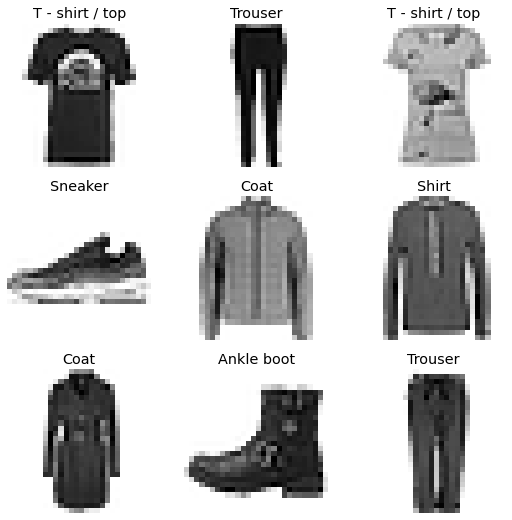

In [ ]:
dls.show_batch()

Verify the items and their shapes in a single batch 

In [ ]:
xb, yb = dls.one_batch()

In [ ]:
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
dls.c # 10 classes as targets

10

In [ ]:
dls.vocab # targets vocabulary

['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T - shirt / top', 'Trouser']

## Train the Model

For training a image classification model, resnet architecture (a form on convolution neural network) is used as our backbone and fully connected (fc) linear layer as our head. In order for the linear layer to predict the outputs as one of the classes, pass the number of classes in order to configure the final layer. For overview review [this resource](https://www.indusmic.com/post/transfer-learning-and-fine-tuning-of-neural-networks) about [transfer learning](https://www.ruder.io/transfer-learning/) and fine tuning.

Review the model layers

In [ ]:
#gpu required
model = resnet34(num_classes=dls.c).cuda()

In [ ]:
#gpu required
model.avgpool, model.fc

In [ ]:
# Uncomment this line to validate if the model accepts single batch as input
# model(xb)

We can access the convolutional layers as attributes of the model. 

Input to the convolutional layer is set as 3 channel (RGB) image but the images used as inputs are single channel images. Let's update the input channel to single channel.

In [ ]:
#gpu required
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
#gpu required
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
#gpu required
model.cuda();

In [ ]:
#gpu required
model(xb);

### Learner

`Learner` is a class that combines the ingredients such as data, model and metrics used to train a model. 

In [ ]:
learn = Learner(dls, model, metrics=accuracy)

`pretrained=False` type setting is used since the fashnion mnist is not similar dataset as Imagenet so keeping all the layers are trainable. If in case `pretrained=True`, we may want to freeze the layers except the head and do a bit of fine tuning the head first followed by unfreeze & then train all the layers.

Review the learner summary to know about the input shape, output shape, different layers involved, parameters, trainable, Optimizer used and loss function used.

In [ ]:
learn.summary()

ResNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 14 x 14   
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 7 x 7     
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                            

Learning rate, a hyperparameter used for training can be determined using learning rate finder function in fastai

SuggestedLRs(valley=0.0004786300996784121)

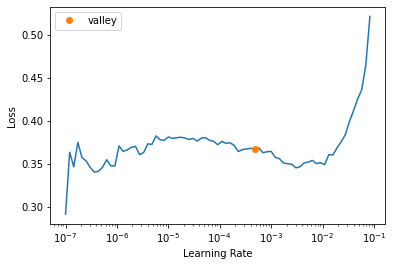

In [ ]:
learn.lr_find()

Train the deep learning model with 6 epochs and with the learning rate obtained from previous step

In [ ]:
learn.fit_one_cycle(6, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.350417,0.380862,0.860200,01:17
1,0.350359,0.350519,0.867500,01:18
2,0.266588,0.297127,0.889900,01:19
3,0.215826,0.248561,0.909700,01:16
4,0.173092,0.230798,0.918000,01:18
5,0.139866,0.226217,0.922900,01:17


Model is trained with an accuracy of **92.3%**. 

### Exporting the trained model

> Tip: Avoid using lambda as Getters during data processing in order to export the model correctly. 

learn.export(fname='export.pkl') will lead to following Pickling error if `lambda` is used in the Data pipeline

```
dsets = Datasets(concat_dsets, [[lambda x: x['image']], [lambda x: x['label'], Categorize]], splits=splits)
```
PicklingError: Can't pickle <function <lambda> at 0x7f378c5aeaf0>: attribute lookup <lambda> on __main__ failed

```

In [ ]:
learn.export(fname='export.pkl')

## Inference

Now load the learner from the exported model. Predict the item ie image using `Learner.predict`. This function performs the necessary transforms on the item used as part of training using the learner.

In [ ]:
item, expected = valid[0]['image'], valid[0]['target']; item, expected

(<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 'Ankle boot')

In [ ]:
learn.predict(item)

('9',
 tensor(9),
 tensor([5.0262e-13, 4.2399e-12, 1.5671e-10, 1.6854e-12, 4.1097e-14, 1.6369e-06,
         1.2831e-10, 1.0092e-05, 1.8003e-10, 9.9999e-01]))

In [ ]:
learn.dls.after_item, learn.dls.after_batch

(Pipeline: img2tensor,
 Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1})

### Recreating `Learner.predict` from the source code 


We can run `learn.predict??` to examine what fastai does and review each line carefully. 

```
def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res
```

Converting the item by applying the transforms and create a dataloader out of it.

In [ ]:
dl = learn.dls.test_dl([item]); dl

<fastai.data.core.TfmdDL>

Internally `learn.predict` calls the `get_preds` method which accepts data loader and returns the input, predictions, the decoded predictions. This applies the same transforms done during training applied on the input during inference.

In [ ]:
inp, preds, _, decoded_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)

Examine the input shape and type

In [ ]:
inp.shape, type(inp)

(torch.Size([1, 1, 28, 28]), fastai.torch_core.TensorImageBW)

In [ ]:
tuplify(decoded_preds)

(tensor([9]),)

In [ ]:
type(learn.dls.decode_batch((inp,) + tuplify(decoded_preds))), len(learn.dls.decode_batch((inp,) + tuplify(decoded_preds)))

(fastcore.foundation.L, 1)

In [ ]:
image, prediction = learn.dls.decode_batch((inp,) + tuplify(decoded_preds))[0]; prediction

'9'

In [ ]:
prediction, decoded_preds

('9', tensor([9]))

Let's examine fastai transforms done after item and after batch.

In [ ]:
learn.dls.after_item, learn.dls.after_batch

(Pipeline: img2tensor,
 Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1})

In [ ]:
type_tfms = Pipeline([get_image_attr])
item_tfms = Pipeline([img2tensor])
batch_tfms = Pipeline([IntToFloatTensor])

In [ ]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9,
 'is_valid': False}

In [ ]:
img = type_tfms(train[0]);img.shape

(28, 28)

In [ ]:
item_tfms(img).shape

torch.Size([1, 28, 28])

In [ ]:
batch_tfms(item_tfms(img).cuda()).shape

torch.Size([1, 28, 28])

From the previous steps, we can uncover fastai magic such as transforms happening behind the scenes.

## Gradio app deployment

Let's deploy the trained model and inference functionality in Gradio app and host the app in [HuggingFace Space](https://huggingface.co/spaces/msivanes).

Steps followed
- Create a new space in HF Space (Profile -> New Space)
- Upload the exported model `export.pkl`
- Move all the necessary functions used as part of the transforms along with the inference provided below. This includes all the getters.
- Add all the dependencies to `requirements.txt`
- Create a gradio interface passing the `classify` function, specifying the inputs(Image) and outputs(Label)
- See the complete [Code](https://huggingface.co/spaces/msivanes/fashion-mnist-classifier/blob/main/app.py) & [Space](https://huggingface.co/spaces/msivanes/fashion-mnist-classifier)

In [ ]:
from fastai.vision.core import PILImageBW, TensorImageBW
from datasets import ClassLabel
import gradio as gr
from fastai.learner import load_learner

def get_image_attr(x): return x['image']
def get_target_attr(x): return x['target']

def img2tensor(im: Image.Image):
    return TensorImageBW(array(im)).unsqueeze(0)

classLabel = ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

def add_target(x:dict):
    x['target'] = classLabel.int2str(x['label'])
    return x

learn = load_learner('export.pkl', cpu=True)

def classify(inp):
    img = PILImageBW.create(inp)
    item = dict(image=img)
    pred, _, _ = learn.predict(item)
    return classLabel.int2str(int(pred))

In [ ]:
fname='shoes.jpg'
classify(fname)

'Ankle boot'

In [ ]:
fname1 = 't-shirt.jpg'
classify(fname1)

'T - shirt / top'

Note: This is my project write up for WalkWithFastai revisited course as one of my goal for this course is to get comfortable with low level API, debug issues diving into the source, uncovering the fastai magic. Thanks to Zach Mueller for an excellent course.

## References
  - https://store.walkwithfastai.com/walk-with-fastai-revisited 
  - https://walkwithfastai.com/MNIST 
  - https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb